# Ensemble

In [4]:
import pandas as pd 
import numpy as np 

## Setting Up the Data 

In [5]:
# linear regression
linreg_train_test = pd.read_csv('linreg_final_20230825_output.csv')
linreg_upcoming = pd.read_csv('linreg_final_20230825_full_predictions.csv')

# light gbm
lgbm_train_test = pd.read_csv('2_output.csv')
lgbm_upcoming = pd.read_csv('2_full_predictions.csv')

# train_test 
def key_pred_creator(df,model_name):
    df['KEY'] = df['Team']+'_'+df['Season'].astype(str)
    df.columns = ['Actual',model_name+'_predictions','Team','Season','SUBSET','KEY']
    return df 

linreg_train_test = key_pred_creator(linreg_train_test,'linreg')
lgbm_train_test = key_pred_creator(lgbm_train_test,'lgbm')

train_test = lgbm_train_test.merge(linreg_train_test[['KEY','linreg_predictions']],how='left',on='KEY')

# upcoming 
linreg_upcoming = linreg_upcoming[['Team','Predicted Wins']].copy()
lgbm_upcoming = lgbm_upcoming[['Team','Predicted Wins']].copy()

linreg_upcoming.columns = ['Team','linreg_predictions']
lgbm_upcoming.columns = ['Team','lgbm_predictions']

upcoming = lgbm_upcoming.merge(linreg_upcoming,how='left',on='Team')

In [6]:
train_test

,Actual,lgbm_predictions,Team,Season,SUBSET,KEY,linreg_predictions
0,0.0,0.0,Hawks,2001,TRAIN,Hawks_2001,-0.184665
1,0.0,0.0,Cavaliers,2001,TRAIN,Cavaliers_2001,1.979811
2,0.0,0.0,Bulls,2001,TRAIN,Bulls_2001,-2.011062
3,0.0,0.0,Nuggets,2001,TRAIN,Nuggets_2001,1.730031
4,0.0,0.0,Warriors,2001,TRAIN,Warriors_2001,-0.660812
...,...,...,...,...,...,...,...
650,0.0,7.0,Jazz,2022,TEST,Jazz_2022,3.713377
651,11.0,16.0,Celtics,2022,TEST,Celtics_2022,7.761753
652,16.0,16.0,Nuggets,2022,TEST,Nuggets_2022,4.613603
653,13.0,16.0,Heat,2022,TEST,Heat_2022,7.253872


In [7]:
upcoming

,Team,lgbm_predictions,linreg_predictions
0,Nets,0.0,2.221440
1,Wizards,0.0,0.903769
2,Jazz,0.0,1.950131
3,Thunder,0.0,-0.232720
4,Spurs,0.0,-1.075769
5,Trail Blazers,0.0,0.012623
6,Pacers,0.0,0.839941
7,Magic,0.0,1.026161
8,Pistons,0.0,-0.362740
9,Hornets,0.0,-1.360432


In [8]:
train = train_test[train_test['SUBSET']=='TRAIN'].copy()
test = train_test[train_test['SUBSET']=='TEST'].copy()
x_train = train.drop(['Actual','Team','Season','KEY','SUBSET'],axis=1)
y_train = train['Actual']
x_test = test.drop(['Actual','Team','Season','KEY','SUBSET'],axis=1)
y_test = test['Actual']

In [9]:
x_train

,lgbm_predictions,linreg_predictions
0,0.0,-0.184665
1,0.0,1.979811
2,0.0,-2.011062
3,0.0,1.730031
4,0.0,-0.660812
...,...,...
620,7.0,0.245799
621,7.0,6.882027
622,7.0,-0.580839
623,16.0,7.334025


## Modeling

In [10]:
# basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# for feature reduction 
from sklearn import feature_selection
from sklearn import pipeline

# for the modeling
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import sklearn

# getting rid of the warnings 
import warnings
warnings.filterwarnings('ignore')

In [11]:
linreg = LinearRegression()

In [12]:
param_grid = {
                'fit_intercept': [True,False]
            }

clf = GridSearchCV(linreg, 
                           param_grid, 
                           scoring='neg_root_mean_squared_error', 
                           cv = 5,
                           return_train_score=True,
                           verbose = 10, 
                           n_jobs = -1
                  )

In [13]:
# Fitting the model 
clf.fit(x_train,y_train)

print("Tuned Hyperparameters :", clf.best_params_)
print("Best Score :",clf.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Tuned Hyperparameters : {'fit_intercept': False}
Best Score : -3.5655942049361213


In [14]:
# storing the CV results 
cv = pd.DataFrame(clf.cv_results_)

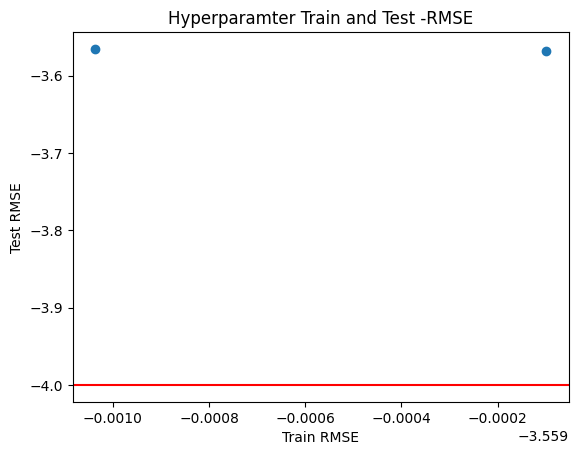

In [15]:
#Plotting the test and train gini to select best parameter
import matplotlib.pyplot as plt
plt.scatter(cv['mean_train_score'],cv['mean_test_score'] )
plt.axhline(0.-4, color='r', linestyle='-')
plt.xlabel('Train RMSE')
plt.ylabel('Test RMSE')
#for i in range(cv.shape[0]):
#    plt.text(x=cv['mean_train_score'][i],y=cv['mean_test_score'][i]+0.03,s=cv['rank_test_score'][i],fontdict=dict(size=5))
plt.title('Hyperparamter Train and Test -RMSE')
plt.show()

In [16]:
cv

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_fit_intercept,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.003046,0.000154,0.001215,0.000100,True,{'fit_intercept': True},-3.434544,-3.642597,-3.392612,-3.444726,...,-3.568576,0.199609,2,-3.593829,-3.540400,-3.603909,-3.592191,-3.465163,-3.559099,0.051928
1,0.002746,0.000032,0.001200,0.000064,False,{'fit_intercept': False},-3.435765,-3.643863,-3.393557,-3.445296,...,-3.565594,0.192517,1,-3.594056,-3.540608,-3.604241,-3.592199,-3.469076,-3.560036,0.050591


In [17]:
clf.best_estimator_.get_params()

{'copy_X': True, 'fit_intercept': False, 'n_jobs': None, 'positive': False}

## Evaluation

### Train 

In [18]:
predictions = clf.predict(x_train)

In [19]:
mse = sklearn.metrics.mean_squared_error(y_train,predictions)
mae = sklearn.metrics.mean_absolute_error(y_train,predictions)
r2 = sklearn.metrics.r2_score(y_train,predictions)
rmse = np.sqrt(mse)

In [20]:
train_output = pd.DataFrame({'Actual':y_train,'Prediction':predictions})
train_output['Team'] = train['Team']
train_output['Season'] = train['Season']
train_output.sort_values(['Season','Prediction'],inplace=True)
metrics_list = ['MSE','MAE','R2','RMSE']
values = [mse,mae,r2,rmse]
train_results = pd.DataFrame({'METRIC':metrics_list,'VALUE':values})
train_results = train_results.transpose().reset_index(drop=True)
train_results.columns = train_results.iloc[0,:]
train_results = train_results.tail(1)

In [21]:
train_output.tail()

,Actual,Prediction,Team,Season
609,6.0,4.994047,76ers,2021
619,7.0,6.240544,Bucks,2021
621,7.0,6.243916,Suns,2021
624,2.0,7.803002,Jazz,2021
623,0.0,7.973355,Nets,2021


In [22]:
train_results

,MSE,MAE,R2,RMSE
1,12.683901,2.535707,0.320885,3.561447


### Test 

In [23]:
predictions = clf.predict(x_test)

In [24]:
mse = sklearn.metrics.mean_squared_error(y_test,predictions)
mae = sklearn.metrics.mean_absolute_error(y_test,predictions)
r2 = sklearn.metrics.r2_score(y_test,predictions)
rmse = np.sqrt(mse)

In [25]:
test_output = pd.DataFrame({'Actual':y_test,'Prediction':predictions})
test_output['Team'] = test['Team']
test_output['Season'] = test['Season']
test_output.sort_values(['Season','Prediction'],inplace=True)
metrics_list = ['MSE','MAE','R2','RMSE']
values = [mse,mae,r2,rmse]
test_results = pd.DataFrame({'METRIC':metrics_list,'VALUE':values})
test_results = test_results.transpose().reset_index(drop=True)
test_results.columns = test_results.iloc[0,:]
test_results = test_results.tail(1)

In [26]:
test_output.head()

,Actual,Prediction,Team,Season
636,0.0,-1.722899,Thunder,2022
627,0.0,-0.389279,Rockets,2022
631,0.0,-0.347123,Magic,2022
638,0.0,-0.094373,Pistons,2022
637,0.0,-0.005944,Wizards,2022


In [27]:
test_results

,MSE,MAE,R2,RMSE
1,10.568251,2.337536,0.42647,3.250885


### Upcoming Season 

In [28]:
x_up = upcoming[clf.best_estimator_.feature_names_in_]
x_up.head()

,lgbm_predictions,linreg_predictions
0,0.0,2.221440
1,0.0,0.903769
2,0.0,1.950131
3,0.0,-0.232720
4,0.0,-1.075769


In [29]:
predictions = clf.predict(x_up)
final_output = x_up.copy() 
final_output['Predicted Wins'] = predictions
final_output['Predicted Wins (Rounded)'] = [round(x) for x in predictions]
final_output['Team'] = upcoming['Team']
def rounds(x):
    if x < 4:
        return 'R1/Lottery'
    elif 4<=x<8:
        return 'Second Round'
    elif 8<=x<12: 
        return 'Conf. Finals'
    elif 12<=x<16:
        return 'Finals'
    elif x>=16:
        return 'Champions'
final_output['Round'] = [rounds(x) for x in final_output['Predicted Wins']]
final_output.sort_values('Predicted Wins',inplace=True)
fo = final_output[['Team','Predicted Wins','Predicted Wins (Rounded)','Round']]
fo

,Team,Predicted Wins,Predicted Wins (Rounded),Round
9,Hornets,-1.020520,-1,R1/Lottery
10,Rockets,-0.936822,-1,R1/Lottery
4,Spurs,-0.806982,-1,R1/Lottery
8,Pistons,-0.272107,0,R1/Lottery
3,Thunder,-0.174573,0,R1/Lottery
5,Trail Blazers,0.009469,0,R1/Lottery
6,Pacers,0.630077,1,R1/Lottery
1,Wizards,0.677957,1,R1/Lottery
7,Magic,0.769769,1,R1/Lottery
2,Jazz,1.462880,1,R1/Lottery


In [30]:
len(list(final_output['Team']))

30

In [31]:
ec_teams = ['Hornets',
 'Wizards',
 'Hawks',
 'Pacers',
 'Magic',
 'Pistons',
 'Raptors',
 'Knicks',
 'Bulls',
 'Cavaliers',
 'Nets',
 '76ers',
 'Heat',
 'Celtics',
 'Bucks']
wc_teams = ['Thunder',
 'Rockets',
 'Spurs',
 'Trail Blazers',
 'Kings',
 'Pelicans',
 'Grizzlies',
 'Timberwolves',
 'Jazz',
 'Warriors',
 'Mavericks',
 'Lakers',
 'Clippers',
 'Suns',
 'Nuggets']

In [32]:
ec = fo[fo['Team'].isin(ec_teams)]
wc = fo[fo['Team'].isin(wc_teams)]

In [33]:
print("Bet to Win EC: ")
ecb = ec.sort_values('Predicted Wins').tail(4)
ecb

Bet to Win EC: 


,Team,Predicted Wins,Predicted Wins (Rounded),Round
26,Heat,3.923902,4,R1/Lottery
21,76ers,5.023168,5,Second Round
14,Celtics,6.160964,6,Second Round
29,Bucks,7.391094,7,Second Round


In [34]:
print("Bet to Win WC: ")
wcb = wc.sort_values('Predicted Wins').tail(4)
wcb

Bet to Win WC: 


,Team,Predicted Wins,Predicted Wins (Rounded),Round
19,Mavericks,3.681247,4,R1/Lottery
20,Suns,5.083031,5,Second Round
23,Warriors,5.180739,5,Second Round
22,Nuggets,7.278719,7,Second Round


In [35]:
print("Bet to Win NBA Finals: ")
fob = fo.sort_values('Predicted Wins').tail(4)
fob

Bet to Win NBA Finals: 


,Team,Predicted Wins,Predicted Wins (Rounded),Round
23,Warriors,5.180739,5,Second Round
14,Celtics,6.160964,6,Second Round
22,Nuggets,7.278719,7,Second Round
29,Bucks,7.391094,7,Second Round


## Writing Info 

In [36]:
train_output['SUBSET'] = 'TRAIN'
test_output['SUBSET'] = 'TEST'
total_output = pd.concat([train_output,test_output])

In [37]:
train_results['SUBSET'] = 'TRAIN'
test_results['SUBSET'] = 'TEST'
total_results = pd.concat([train_results,test_results])
total_results

,MSE,MAE,R2,RMSE,SUBSET
1,12.683901,2.535707,0.320885,3.561447,TRAIN
1,10.568251,2.337536,0.42647,3.250885,TEST


In [38]:
model_name = input()

ens_20230829


In [39]:
initial_path = ''
cv_path = initial_path+model_name+'_cv_results.csv'
output_path = initial_path+model_name+'_output.csv'
results_path = initial_path+model_name+'_results.csv'
predictions_path = initial_path+model_name+'_full_predictions.csv'
ec_path = initial_path+model_name+'_ecf_predictions.csv'
wc_path = initial_path+model_name+'_wcf_predictions.csv'
f_path = initial_path+model_name+'_finals_predictions.csv'
print(cv_path)
print(output_path)
print(results_path)
print(predictions_path)
print(ec_path)
print(wc_path)
print(f_path)

ens_20230829_cv_results.csv
ens_20230829_output.csv
ens_20230829_results.csv
ens_20230829_full_predictions.csv
ens_20230829_ecf_predictions.csv
ens_20230829_wcf_predictions.csv
ens_20230829_finals_predictions.csv


In [40]:
cv.to_csv(cv_path,index=False)
total_output.to_csv(output_path,index=False)
total_results.to_csv(results_path,index=False)
fo.to_csv(predictions_path,index=False)
ecb.to_csv(ec_path,index=False)
wcb.to_csv(wc_path,index=False)
fob.to_csv(f_path,index=False)

In [41]:
import pickle

# save the model to disk
filename = model_name+'.sav'
pickle.dump(clf, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
#loaded_model = pickle.load(open(filename, 'rb'))
#result = loaded_model.score(X_test, Y_test)
#print(result)

## What if I had Used this Model Last Year? 

In [42]:
ec2 = test_output[test_output['Team'].isin(ec_teams)]
wc2 = test_output[test_output['Team'].isin(wc_teams)]

In [43]:
print("Bet to Win EC: ")
ecb2 = ec2.sort_values('Prediction').tail(4)
ecb2

Bet to Win EC: 


,Actual,Prediction,Team,Season,SUBSET
649,7.0,5.139824,76ers,2022,TEST
647,1.0,6.198077,Bucks,2022,TEST
653,13.0,7.913229,Heat,2022,TEST
651,11.0,8.294213,Celtics,2022,TEST


In [44]:
print("Bet to Win WC: ")
wcb2 = wc2.sort_values('Prediction').tail(4)
wcb2

Bet to Win WC: 


,Actual,Prediction,Team,Season,SUBSET
645,0.0,4.885307,Mavericks,2022,TEST
646,6.0,5.707858,Warriors,2022,TEST
652,16.0,5.932646,Nuggets,2022,TEST
654,6.0,7.736325,Suns,2022,TEST


In [45]:
print("Bet to Win NBA Finals: ")
fob2 = test_output.sort_values('Prediction').tail(4)
fob2

Bet to Win NBA Finals: 


,Actual,Prediction,Team,Season,SUBSET
647,1.0,6.198077,Bucks,2022,TEST
654,6.0,7.736325,Suns,2022,TEST
653,13.0,7.913229,Heat,2022,TEST
651,11.0,8.294213,Celtics,2022,TEST


In [46]:
clf.best_estimator_.feature_names_in_

array(['lgbm_predictions', 'linreg_predictions'], dtype=object)

In [47]:
clf.best_estimator_.coef_

array([0.15448614, 0.75014425])